<a href="https://colab.research.google.com/github/MohamedAbuAmira/Deep-Learning-Projects/blob/master/crnn_keras_for_handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNDER CREATING NOTEBOOK**

https://github.com/qjadud1994/CRNN-Keras

* **By Mohammed Abu Amira**
* **[Linkedin](https://www.linkedin.com/in/mohamedabuamira/)**
* **[Github](https://github.com/MohamedAbuAmira)**

This is Keras implementation of Convolutional Recurrent Neural Network(CNN + RNN + CTC) for Handwriting Recognition Dataset. 
This notebook applys the paper "[An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)"

# Introduction


Convolutional Recurrent Neural Network (CRNN) is a combination of CNN, RNN, and CTC(Connectionist Temporal Classification) loss for image-based sequence recognition tasks, such as scene text recognition and OCR. The network architecture has been taken from this [paper](https://arxiv.org/pdf/1507.05717.pdf) published in 2015.

![](https://nanonets.com/blog/content/images/2019/08/Screen-Shot-2019-08-13-at-2.07.18-AM.png)

This neural network architecture integrates feature extraction, sequence modeling, and transcription into a unified framework. This model does not need character segmentation. The convolution neural network extracts features from the input image(text detected region). The deep bidirectional recurrent neural network predicts label sequence with some relation between the characters. The transcription layer converts the per-frame made by RNN into a label sequence. There are two modes of transcription, namely the lexicon-free and lexicon-based transcription. In the lexicon-based approach, the highest probable label sequence will be predicted. ([Source](https://nanonets.com/blog/deep-learning-ocr/))

# To Use this notebook in Colab

In [2]:
# To Use it on Colab

def download_kaggle_dataset(API_command_dataset, use_function=False):
  '''
  Function To Download Dataset From Kaggle To the Working Directory

  Parameters
        ----------
        use: boolean
            To use this function 
        API_command_dataset: str
            API Command for kaggle dataset
  '''
  if use_function:

      # How to use Kaggle dataset in Colab: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676
      # Then we need to upload kaggle.json file.

      !pip install -q kaggle
      
      from google.colab import files
      import os
      import zipfile

      # Kaggle's beta API
      print("Please upload your API json file for your kaggle account")
      files.upload()

      # Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API
      !mkdir ~/.kaggle
      !cp kaggle.json ~/.kaggle/
      !chmod 600 ~/.kaggle/kaggle.json

      # as exmple: API_command_dataset="kaggle datasets download -d landlord/handwriting-recognition"
      !kaggle datasets download -d landlord/handwriting-recognition

      # get the working directory
      working_directory=os.getcwd()

      # get the folder name of dataset
      folder_name= API_command_dataset.split('/')[-1]

      zip_file_name= folder_name + ".zip"
      zip_file_path= working_directory + '/' + zip_file_name

      
      extracting_path = os.path.join(working_directory, folder_name) 
      os.mkdir(extracting_path) # make directory to extract the zip file in it

      
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(extracting_path)

      # delete the zip file
      os.remove(zip_file_path)

      print("The zip file extracted in {} folder".format(folder_name))

      print("The files in {} Folder are: {}".format(folder_name, os.listdir(extracting_path)))

In [3]:
download_kaggle_dataset(use_function=True, API_command_dataset="kaggle datasets download -d landlord/handwriting-recognition")

Please upload your API json file for your kaggle account


Saving kaggle.json to kaggle.json
 99% 1.24G/1.26G [00:14<00:00, 101MB/s] 
100% 1.26G/1.26G [00:14<00:00, 92.1MB/s]
The zip file extracted in handwriting-recognition folder
The files in handwriting-recognition Folder are: ['train_v2', 'written_name_test_v2.csv', 'written_name_validation_v2.csv', 'written_name_train_v2.csv', 'validation_v2', 'test_v2']


# Importing Libraries 

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Enabling and testing the GPU

In [5]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!)


In [6]:
print("keras Version: ", keras.__version__)
print("TensorFlow Version: ", tf.__version__)

keras Version:  2.4.3
TensorFlow Version:  2.3.0


# Load files and images

In [7]:
# creat data dirctories, we my use it later
working_directory=os.getcwd()

DATA_DIR = working_directory + '/handwriting-recognition/'

TRAIN_CSV = DATA_DIR + 'written_name_train_v2.csv'
VALID_CSV = DATA_DIR +'written_name_validation_v2.csv'
TEST_CSV  = DATA_DIR + 'written_name_test_v2.csv' 

TRAIN_IMG_DIR = DATA_DIR + 'train_v2/train/' 
VALID_IMG_DIR = DATA_DIR + 'validation_v2/validation/'
TEST_IMG_DIR  = DATA_DIR + 'test_v2/test/'                             

In [8]:
IMG_DIRs=[TRAIN_IMG_DIR, VALID_IMG_DIR, TEST_IMG_DIR]

In [9]:
TRAIN_IMG_FILENAMES=[]
VALID_IMG_FILENAMES=[]
TEST_IMG_FILENAMES=[]
IMG_FILENAMES=[TRAIN_IMG_FILENAMES, VALID_IMG_FILENAMES, TEST_IMG_FILENAMES]

In [10]:
# Store All filenames as list, for train, valid, test

for img_path in IMG_DIRs:
    for _, _, filenames in os.walk(img_path):
        for filename in filenames:
            IMG_FILENAMES[IMG_DIRs.index(img_path)].append(os.path.join(img_path, filename))
            

In [11]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
VALID_DF = pd.read_csv(VALID_CSV)
TEST_DF  = pd.read_csv(TEST_CSV)

# Check Dataframes and display images

In [12]:
TRAIN_DF.head(10)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
5,TRAIN_00006.jpg,LUCIE
6,TRAIN_00007.jpg,NASSIM
7,TRAIN_00008.jpg,ASSRAOUI
8,TRAIN_00009.jpg,LAVIAN
9,TRAIN_00010.jpg,MAEVA


In [13]:
TRAIN_DF.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_282776.jpg,THOMAS
freq,1,1825


In [14]:
print("The number of files in Train image directory: ", len(TRAIN_IMG_FILENAMES))

The number of files in Train image directory:  330961


In [15]:
VALID_DF.head(10)

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
5,VALIDATION_0006.jpg,UNREADABLE
6,VALIDATION_0007.jpg,PICHON
7,VALIDATION_0008.jpg,DANIEL
8,VALIDATION_0009.jpg,JEREMY
9,VALIDATION_0010.jpg,JEAN-MICHEL


In [16]:
VALID_DF.describe()

,FILENAME,IDENTITY
count,41370,41292
unique,41370,20227
top,VALIDATION_1980.jpg,THOMAS
freq,1,219


In [17]:
print("The number of files in Valid image directory: ", len(VALID_IMG_FILENAMES))

The number of files in Valid image directory:  41370


In [18]:
TEST_DF.head(10)

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
5,TEST_0006.jpg,MARTIN
6,TEST_0007.jpg,VALENTINE
7,TEST_0008.jpg,LORAS
8,TEST_0009.jpg,THIBAULT
9,TEST_0010.jpg,AZABI


In [19]:
TEST_DF.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_21850.jpg,THOMAS
freq,1,227


In [20]:
print("The number of files in Test image directory: ", len(TEST_IMG_FILENAMES))

The number of files in Test image directory:  41370


In [21]:
# Define a function to display images

def display_six_images():
  plt.figure(figsize=(15,15))
  for i in range(6):
    plt.subplot(3,3 ,1+i)

    img_file= TRAIN_IMG_DIR + TRAIN_DF.loc[i, 'FILENAME']
    img_title = TRAIN_DF.loc[i, 'IDENTITY']

    img=plt.imread(img_file)
    plt.imshow(img)
    plt.title(img_title)
    plt.tight_layout()
  plt.show

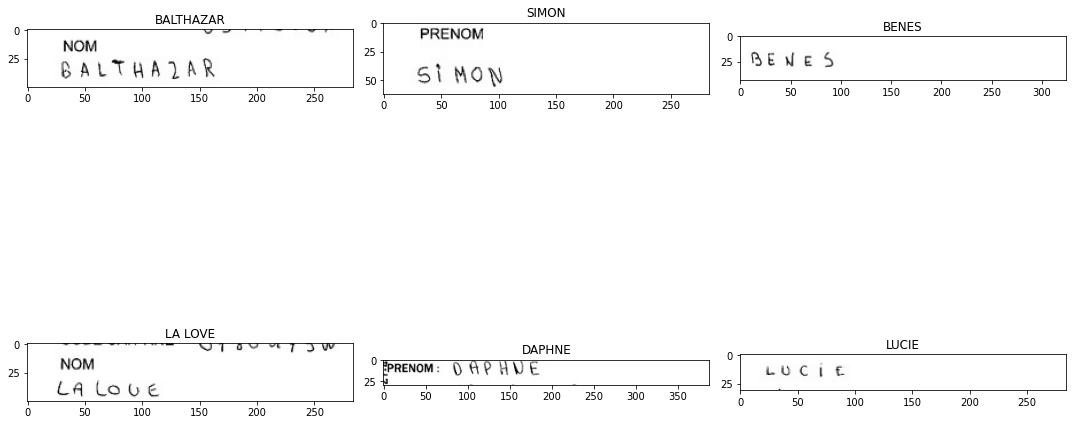

In [22]:
display_six_images()

# Clean Data

We note the number of files in images directories are equal with number of entries in 'FILENAME' column in dataframes. 
but the number of entries in 'IDENTITY' column is different with 'FILENAME' column, this because there are NANs values. Let's check them

In [23]:
# check nan values count

print("Number of NaNs in train dataframe : ", TRAIN_DF['IDENTITY'].isnull().sum())
print("Number of NaNs in valid dataframe : ", VALID_DF['IDENTITY'].isnull().sum())
print("Number of NaNs in test dataframe  : ", TEST_DF['IDENTITY'].isnull().sum())

Number of NaNs in train dataframe :  565
Number of NaNs in valid dataframe :  78
Number of NaNs in test dataframe  :  70


I will drop out all NaNs rows in all dataframes, and delete the image files corresponding to those rows; that means get the indexes of NaNs rows then take the filename for that row, then remove this file from filename list

In [24]:
NAN_index_train_df = TRAIN_DF['IDENTITY'].index[TRAIN_DF['IDENTITY'].isnull()]
NAN_index_valid_df = VALID_DF['IDENTITY'].index[VALID_DF['IDENTITY'].isnull()]
NAN_index_test_df  = TEST_DF['IDENTITY'].index[TEST_DF['IDENTITY'].isnull()]


FILENAME    TEST_0945.jpg
IDENTITY              NaN
Name: 944, dtype: object

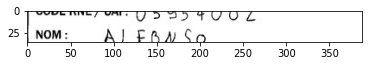

In [25]:
# check example, 
nan_index=NAN_index_test_df[0]
imgfile=TEST_IMG_DIR + TEST_DF.loc[nan_index, 'FILENAME']
img=plt.imread(imgfile)
plt.imshow(img)
TEST_DF.loc[nan_index, :]

In [26]:

# Drop all nan entries in dataframes

TRAIN_DF.dropna(axis=0, inplace=True)
VALID_DF.dropna(axis=0, inplace=True)
TEST_DF.dropna(axis=0, inplace=True)


In [27]:
# Check all good
print("Number of NaNs in All dataframes : ", TRAIN_DF['IDENTITY'].isnull().sum() + VALID_DF['IDENTITY'].isnull().sum() + TEST_DF['IDENTITY'].isnull().sum())

Number of NaNs in All dataframes :  0


There are some images in data with the label 'UNREADABLE'. Lets check those images and remove them

In [28]:
unreadable_index_train_df = TRAIN_DF['IDENTITY'].index[TRAIN_DF['IDENTITY']=='UNREADABLE']
unreadable_index_valid_df = VALID_DF['IDENTITY'].index[VALID_DF['IDENTITY']=='UNREADABLE']
unreadable_index_test_df  = TEST_DF['IDENTITY'].index[TEST_DF['IDENTITY']=='UNREADABLE']

FILENAME    TRAIN_00807.jpg
IDENTITY         UNREADABLE
Name: 806, dtype: object

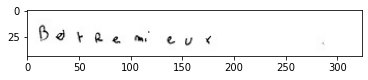

In [29]:
index_=unreadable_index_train_df[0]
imgfile= TRAIN_IMG_DIR + TRAIN_DF.loc[index_, 'FILENAME']
img=plt.imread(imgfile)
plt.imshow(img)
TRAIN_DF.loc[index_, :]

In [30]:
# remove from dataframes 

TRAIN_DF = TRAIN_DF[TRAIN_DF['IDENTITY'] != 'UNREADABLE']
VALID_DF = VALID_DF[VALID_DF['IDENTITY'] != 'UNREADABLE']
TEST_DF = TEST_DF[TEST_DF['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase

In [31]:
TRAIN_DF['IDENTITY'] = TRAIN_DF['IDENTITY'].str.upper()
VALID_DF['IDENTITY'] = VALID_DF['IDENTITY'].str.upper()
TEST_DF['IDENTITY'] = TEST_DF['IDENTITY'].str.upper()

Reset the index and we are done with cleaning.



In [32]:
TRAIN_DF.reset_index(inplace = True, drop=True) 
VALID_DF.reset_index(inplace = True, drop=True)
TEST_DF.reset_index(inplace = True, drop=True)



---



# Define Main Parameters

In [33]:
CHAR_VECTOR = "ABCDEFGHIJKLMNOPQRSTUVWXYZ -'"

letters = [letter for letter in CHAR_VECTOR]

num_of_characters = len(letters) + 1    # +1 for ctc pseudo blank

IMG_WIDTH = 128
IMG_HIGHT = 64

# Network parameters
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE= 32
TEST_BATCH_SIZE= 32


max_text_len = 24                         # max length of input labels
num_of_timestamps = 64                    # max length of predicted labels




# Image Generation

In [51]:
from image_generator import text_to_labels, labels_to_text
from image_generator import TextImageGenerator

In [52]:
# Example
name = 'MOHAMMED TAYSEER'
print(name, '\n',text_to_labels(name))

MOHAMMED TAYSEER 
 [12, 14, 7, 0, 12, 12, 4, 3, 26, 19, 0, 24, 18, 4, 4, 17]


In [53]:
# lables to text, add -1 to labels
labels_to_name=labels_to_text([-1, 12, 14, 7, 0, 12, 12, 4, 3, 26, -1, 19, 0, 24, 18, 4, 4, 17, -1])
print(labels_to_name)


MOHAMMED TAYSEER


## Create Train Dataset

In [65]:
# Instance image generator class for train data

train_data_generator = TextImageGenerator(TRAIN_DF, TRAIN_IMG_DIR, IMG_WIDTH, IMG_HIGHT,
                 TRAIN_BATCH_SIZE, limit_samples=5000)



In [66]:
# process and build texts, images from dir

train_data_generator.build_data()

5000  Image Loading start...
True
5000  Image Loading finish...


## Create Valid Dataset

In [58]:
# Instance image generator class for valid data

valid_data_generator = TextImageGenerator(VALID_DF, VALID_IMG_DIR, IMG_WIDTH, IMG_HIGHT,
                 VALID_BATCH_SIZE, limit_samples=2000)


In [59]:
# process and build texts, images from dir

valid_data_generator.build_data()

2000  Image Loading start...
True
2000  Image Loading finish...


## Create Test Dataset

In [61]:
# Instance image generator class for test data
test_data_generator = TextImageGenerator(TEST_DF, TEST_IMG_DIR, IMG_WIDTH, IMG_HIGHT,
                 TEST_BATCH_SIZE, limit_samples=3000)

In [62]:
# process and build texts, images from dir

test_data_generator.build_data()

3000  Image Loading start...
True
3000  Image Loading finish...


## Visualize the data from dataset

In [74]:
train_batch=next(train_data_generator.next_batch())    # Get batch

In [82]:
inputs, outputs=train_batch

In [90]:
# Get the first sample in batch for inputs


print("Img with shape: ", inputs['the_input'][0].shape)

print("Label: ", inputs['the_labels'][0])
print("The text of this label is: ", labels_to_text(inputs['the_labels'][0]))

print("Input length: ", inputs['input_length'][0])

print("Label length", inputs['label_length'][0])



Img with shape:  (128, 64, 1)
Label:  [ 9. 14. 20.  8. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.]
The text of this label is:  JOUI
Input length:  [62.]
Label length [4.]


In [100]:
outputs['ctc'][0]

0.0

In [124]:
def disply_batch_data(image_batch, label_batch):
  plt.figure(figsize=(4, 4))
  for i in range(1):
    ax = plt.subplot(1, 1, i + 1)
    if(len(image_batch[i].shape) == 3):
       plt.imshow(np.squeeze(image_batch[i]))
    elif(len(image_batch[i].shape) == 2):
      plt.imshow(image_batch[i])
    else:
      print("Higher dimensional data")

    label = label_batch[i]
    plt.title("{}: ({})".format(labels_to_text(label),label))
    plt.axis("off")

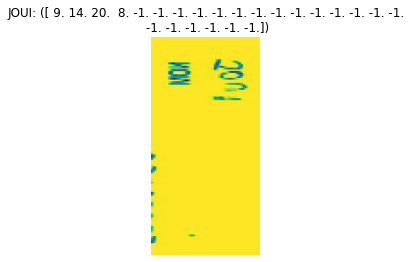

In [125]:
disply_batch_data(inputs['the_input'], inputs['the_labels'])



---



# Create Model and training

In [175]:
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from crnn_model import get_Model
from parameters import *

K.set_learning_phase(0)

In [176]:
# # Model description and training

model = get_Model(training=True)

try:
    model.load_weights('LSTM+BN4--26--0.011.hdf5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

ada = Adam()

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='LSTM+BN5--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=ada)



...New weight data...


In [177]:
# captures output of softmax so we can decode the output during visualization
model.fit(train_data_generator.next_batch(),
                    steps_per_epoch=int(train_data_generator.n / TRAIN_BATCH_SIZE),
                    epochs=30,
                    callbacks=[checkpoint],
                    validation_data=valid_data_generator.next_batch(),
                    validation_steps=int(valid_data_generator.n / VALID_BATCH_SIZE))

Epoch 1/30


InvalidArgumentError: ignored